In [1]:
import torch
import torch.nn as nn
import math
import triton
from einops import rearrange, repeat
import numpy as np

from flash_attn import flash_attn_with_kvcache
from bit_decode import kvcache_pack_int, fwd_kvcache_int

# 1. test

In [2]:
def attention_ref(
    q,
    k,
    v,
):
    """
    Arguments:
        q: (batch_size, seqlen_q, nheads, head_dim)
        k: (batch_size, seqlen_k, nheads_k, head_dim)
        v: (batch_size, seqlen_k, nheads_k, head_dim)
    Output:
        output: (batch_size, seqlen_q, nheads, head_dim)
        attention: (batch_size, nheads, seqlen_q, seqlen_k), softmax after dropout
    """
    dtype_og = q.dtype

    d = q.shape[-1]

    scores = torch.einsum("bthd,bshd->bhts", q / math.sqrt(d), k)
    
    attention = torch.softmax(scores, dim=-1).to(v.dtype)

    output = torch.einsum("bhts,bshd->bthd", attention, v)

    return output.to(dtype=dtype_og), attention.to(dtype=dtype_og)

In [3]:
# Define constants
batch_size = 1
nheads = 32
nheads_k = 32
d = 128

# Sequence length
seqlen_q = 1
seqlen_kv = 4096

# Quantization parameters
quant_mode = "k-channel"
num_bits = 4
pack_nums = 16 / num_bits
group_size = 128

In [4]:
# Set seed and parameters
device = "cuda"
dtype = torch.float16
torch.random.manual_seed(0)

# Initialize tensors
q = torch.randn(batch_size, seqlen_q, nheads, d, device=device, dtype=dtype)
k_cache = torch.randn(batch_size, seqlen_kv, nheads_k, d, device=device, dtype=dtype)
v_cache = torch.randn(batch_size, seqlen_kv, nheads_k, d, device=device, dtype=dtype)

k_cache_rep = repeat(k_cache, "b s h d -> b s (h g) d", g=nheads // nheads_k)
v_cache_rep = repeat(v_cache, "b s h d -> b s (h g) d", g=nheads // nheads_k)

# Reference attention computation
out_ref, _ = attention_ref(q, k_cache_rep, v_cache_rep)

##################### BitDecoding Packing Kernel ##################### 

# Initialize quantization tensors
if quant_mode == "k-channel":
    k_pack   = torch.zeros((batch_size, int(seqlen_kv // pack_nums), nheads_k, d),  dtype=torch.uint16, device=device)
    k_params = torch.zeros((batch_size, int(seqlen_kv // group_size), nheads_k, d), dtype=torch.float32, device=device)
else:
    k_pack   = torch.zeros((batch_size, seqlen_kv, nheads_k, int(d // pack_nums)),  dtype=torch.uint16, device=device)
    k_params = torch.zeros((batch_size, int(d // group_size), nheads_k, seqlen_kv), dtype=torch.float32, device=device)

v_pack   = torch.zeros((batch_size, seqlen_kv, nheads_k, int(d // pack_nums)),  dtype=torch.uint16, device=device)
v_params = torch.zeros((batch_size, int(d // group_size), nheads_k, seqlen_kv), dtype=torch.float32, device=device)

cu_seqlens_k = torch.arange(0, (batch_size + 1) * seqlen_kv, seqlen_kv, dtype=torch.int32, device=device)

kvcache_pack_int(
    k_cache, k_pack, k_params,
    v_cache, v_pack, v_params,
    None, # opt_block_table
    cu_seqlens_k,              
    seqlen_kv,
    quant_mode,
    group_size,
    num_bits
)

sm_scale = 1.0 / math.sqrt(d)
out_bitdecode = fwd_kvcache_int(
                    q,
                    k_pack, k_params, 
                    v_pack, v_params,
                    None, # opt_block_table
                    sm_scale,
                    quant_mode, 
                    group_size,
                    num_bits
                )

print(f"seqlen_kv:{seqlen_kv} BitDecode vs Pytorch: {(out_bitdecode - out_ref).abs().mean().item()}")

print(f"out_ref: \n{out_ref[0,0,0,:8]}")
print(f"out_bitdecode: \n{out_bitdecode[0,0,0,:8]}")

seqlen_kv:4096 BitDecode vs Pytorch: 0.0028667449951171875
out_ref: 
tensor([-0.0581, -0.0140, -0.0241, -0.0495,  0.0539,  0.0224,  0.0342,  0.0048],
       device='cuda:0', dtype=torch.float16)
out_bitdecode: 
tensor([-0.0574, -0.0154, -0.0268, -0.0524,  0.0555,  0.0147,  0.0376,  0.0105],
       device='cuda:0', dtype=torch.float16)


## 2. Benchmark

### Single

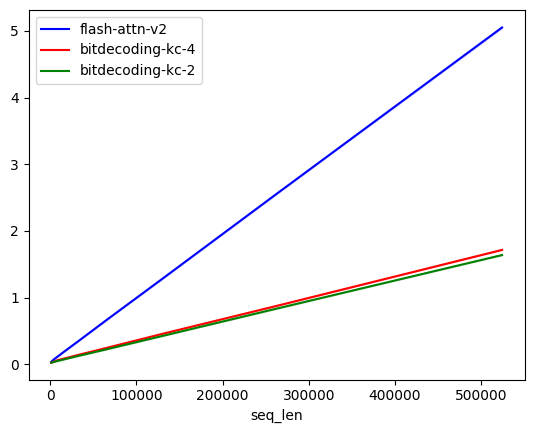

decoding benchmark:
    seq_len  flash-attn-v2  bitdecoding-kc-4  bitdecoding-kc-2
0    1024.0       0.032768          0.024576          0.023552
1    2048.0       0.048128          0.029696          0.028672
2    4096.0       0.072704          0.039936          0.034816
3    8192.0       0.112640          0.060416          0.049152
4   16384.0       0.192512          0.087040          0.074752
5   32768.0       0.349184          0.141312          0.125952
6   65536.0       0.666624          0.246784          0.225280
7  131072.0       1.292288          0.459776          0.428032
8  262144.0       2.551808          0.873472          0.833536
9  524288.0       5.052416          1.715200          1.638400


In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["seq_len"],
        x_vals=[2**i for i in range(10, 20, 1)],
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['flash-attn-v2', 'bitdecoding-kc-4', 'bitdecoding-kc-2'],  # Possible values for `line_arg`.
        line_names=['flash-attn-v2', 'bitdecoding-kc-4', 'bitdecoding-kc-2'],  # Label name for the lines.
        styles=[('blue', '-'), ('red', '-'), ('green', '-')],  # Line color and style.
        plot_name="decoding benchmark",
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    )
)
def benchmark(seq_len, provider):
    torch.random.manual_seed(0)
    device = "cuda"
    dtype = torch.float16

    batch_size = 1
    nheads = 32
    nheads_k = 32
    d = 128
    sm_scale = 1.0 / math.sqrt(d)

    # Quantization parameters
    quant_mode = "k-channel"
    group_size = 128

    q = torch.randn(batch_size, 1, nheads, d, device=device, dtype=dtype)
    k_cache = torch.randn(batch_size, seq_len, nheads_k, d, device=device, dtype=dtype)
    v_cache = torch.randn(batch_size, seq_len, nheads_k, d, device=device, dtype=dtype)

    quantiles = [0.5, 0.2, 0.8]

    if provider == 'flash-attn-v2':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: flash_attn_with_kvcache(q, k_cache, v_cache), quantiles=quantiles)
    elif provider == 'bitdecoding-kc-4':
        num_bits = 4
        pack_nums = 16 / num_bits
        k_pack   = torch.zeros((batch_size, int(seq_len // pack_nums), nheads_k, d),  dtype=torch.uint16, device=device)
        k_params = torch.zeros((batch_size, int(seq_len // group_size), nheads_k, d), dtype=torch.float32, device=device)
        v_pack   = torch.zeros((batch_size, seq_len, nheads_k, int(d // pack_nums)),  dtype=torch.uint16, device=device)
        v_params = torch.zeros((batch_size, int(d // group_size), nheads_k, seq_len), dtype=torch.float32, device=device)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fwd_kvcache_int(q,
                                                                             k_pack, k_params, 
                                                                             v_pack, v_params,
                                                                             None, # opt_block_table
                                                                             sm_scale,
                                                                             quant_mode, 
                                                                             group_size,
                                                                             num_bits), quantiles=quantiles)
    elif provider == 'bitdecoding-kc-2':
        num_bits = 2
        pack_nums = 16 / num_bits
        k_pack   = torch.zeros((batch_size, int(seq_len // pack_nums), nheads_k, d),  dtype=torch.uint16, device=device)
        k_params = torch.zeros((batch_size, int(seq_len // group_size), nheads_k, d), dtype=torch.float32, device=device)
        v_pack   = torch.zeros((batch_size, seq_len, nheads_k, int(d // pack_nums)),  dtype=torch.uint16, device=device)
        v_params = torch.zeros((batch_size, int(d // group_size), nheads_k, seq_len), dtype=torch.float32, device=device)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fwd_kvcache_int(q,
                                                                             k_pack, k_params, 
                                                                             v_pack, v_params,
                                                                             None, # opt_block_table
                                                                             sm_scale,
                                                                             quant_mode, 
                                                                             group_size,
                                                                             num_bits), quantiles=quantiles)
    
    return ms, min_ms, max_ms

benchmark.run(show_plots=True, print_data=True)

### Batches

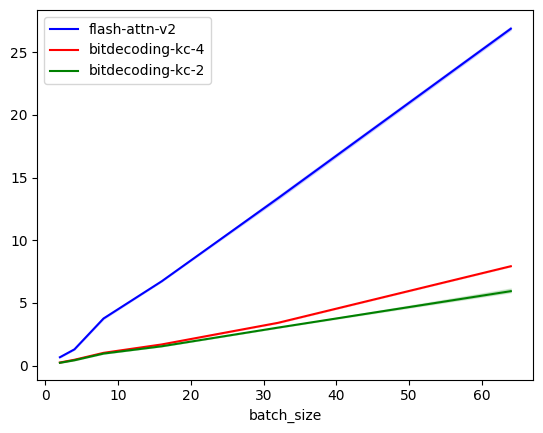

decoding benchmark:
   batch_size  flash-attn-v2  bitdecoding-kc-4  bitdecoding-kc-2
0         2.0       0.665600          0.245760          0.224256
1         4.0       1.295360          0.465920          0.427008
2         8.0       3.757568          1.016832          0.958464
3        16.0       6.727680          1.687552          1.541120
4        32.0      13.357056          3.412992          3.031040
5        64.0      26.876928          7.927808          5.938176


In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["batch_size"],
        x_vals=[2**i for i in range(1, 7, 1)],
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['flash-attn-v2', 'bitdecoding-kc-4', 'bitdecoding-kc-2'],  # Possible values for `line_arg`.
        line_names=['flash-attn-v2', 'bitdecoding-kc-4', 'bitdecoding-kc-2'],  # Label name for the lines.
        styles=[('blue', '-'), ('red', '-'), ('green', '-')],  # Line color and style.
        plot_name="decoding benchmark",
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    )
)
def benchmark(batch_size, provider):
    torch.random.manual_seed(0)
    device = "cuda"
    dtype = torch.float16

    seq_len = 32768
    nheads = 32
    nheads_k = 32
    d = 128
    sm_scale = 1.0 / math.sqrt(d)

    # Quantization parameters
    quant_mode = "k-channel"
    group_size = 128

    q = torch.randn(batch_size, 1, nheads, d, device=device, dtype=dtype)
    k_cache = torch.randn(batch_size, seq_len, nheads_k, d, device=device, dtype=dtype)
    v_cache = torch.randn(batch_size, seq_len, nheads_k, d, device=device, dtype=dtype)

    quantiles = [0.5, 0.2, 0.8]

    if provider == 'flash-attn-v2':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: flash_attn_with_kvcache(q, k_cache, v_cache), quantiles=quantiles)
    elif provider == 'bitdecoding-kc-4':
        num_bits = 4
        pack_nums = 16 / num_bits
        k_pack   = torch.zeros((batch_size, int(seq_len // pack_nums), nheads_k, d),  dtype=torch.uint16, device=device)
        k_params = torch.zeros((batch_size, int(seq_len // group_size), nheads_k, d), dtype=torch.float32, device=device)
        v_pack   = torch.zeros((batch_size, seq_len, nheads_k, int(d // pack_nums)),  dtype=torch.uint16, device=device)
        v_params = torch.zeros((batch_size, int(d // group_size), nheads_k, seq_len), dtype=torch.float32, device=device)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fwd_kvcache_int(q,
                                                                             k_pack, k_params, 
                                                                             v_pack, v_params,
                                                                             None, # opt_block_table
                                                                             sm_scale,
                                                                             quant_mode, 
                                                                             group_size,
                                                                             num_bits), quantiles=quantiles)
    elif provider == 'bitdecoding-kc-2':
        num_bits = 2
        pack_nums = 16 / num_bits
        k_pack   = torch.zeros((batch_size, int(seq_len // pack_nums), nheads_k, d),  dtype=torch.uint16, device=device)
        k_params = torch.zeros((batch_size, int(seq_len // group_size), nheads_k, d), dtype=torch.float32, device=device)
        v_pack   = torch.zeros((batch_size, seq_len, nheads_k, int(d // pack_nums)),  dtype=torch.uint16, device=device)
        v_params = torch.zeros((batch_size, int(d // group_size), nheads_k, seq_len), dtype=torch.float32, device=device)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fwd_kvcache_int(q,
                                                                             k_pack, k_params, 
                                                                             v_pack, v_params,
                                                                             None, # opt_block_table
                                                                             sm_scale,
                                                                             quant_mode, 
                                                                             group_size,
                                                                             num_bits), quantiles=quantiles)
    
    return ms, min_ms, max_ms

benchmark.run(show_plots=True, print_data=True)